In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import random, os
from IPython.display import display
import pandas as pd
from itertools import cycle
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp

In [16]:
csv_directory = "/home/tushaar/Desktop/phishing_corpus/csv/"
feature_selection_csv_directory = "/home/tushaar/Desktop/phishing_corpus/feature_selection_csv/"

files = ['dataset_HP', 'dataset_HS', 'dataset_HSP']

In [17]:
def get_data(filename):
    filename = feature_selection_csv_directory + filename + '.csv'
    if os.path.exists(filename):
        df = pd.read_csv(filename)
    else:
        print "Run `feature_selection.py` to get CSV"
    return df

filename = files[2]
df = get_data(filename)
display(df.head())

,body_noFunctionWords,url_noIntLinks,body_richness,url_noLinks,url_linkText,send_noCharacters,body_noCharacters,subj_reply,send_noWords,url_nonModalHereLinks,...,url_noPorts,subj_forward,subj_debit,body_noDistinctWords,script_nonModalJsLoads,script_popups,send_diffSenderReplyTo,script_javaScript,script_statusChange,label
0,2,0,0.178988,1,False,35,257,False,3,False,...,0,False,False,40,False,False,False,False,False,S
1,3,0,0.132988,2,False,20,579,False,1,False,...,0,False,False,65,False,False,False,False,False,S
2,7,0,0.159965,1,False,49,14972,True,7,False,...,0,False,False,1146,False,False,False,False,False,S
3,3,0,0.166987,2,True,23,1042,False,1,False,...,0,False,False,127,False,False,False,False,False,S
4,4,3,0.105160,31,False,22,9205,False,4,False,...,0,False,False,427,False,False,False,False,False,S


In [21]:
def get_features(df):
    features = list(df.columns[:-1])
    return features

features = get_features(df)
display(features)
print len(features)

def attribute_types(df, attribute):
    return df[attribute].unique()

def preprocessing(df, label_column):
    transformed_df = df.copy()
    labels = attribute_types(df, label_column)
    mapping = {name : number for number, name in enumerate(labels)}
    transformed_df[label_column] = transformed_df[label_column].replace(mapping)
    return mapping, transformed_df

mapping, transformed_df = preprocessing(df, 'label')
display(transformed_df.head())
display(mapping)

['body_noFunctionWords',
 'url_noIntLinks',
 'body_richness',
 'url_noLinks',
 'url_linkText',
 'send_noCharacters',
 'body_noCharacters',
 'subj_reply',
 'send_noWords',
 'url_nonModalHereLinks',
 'url_noIpAddresses',
 'body_html',
 'url_atSymbol',
 'body_noWords',
 'subj_richness',
 'url_maxNoPeriods',
 'url_noDomains',
 'url_ipAddress',
 'body_verifyYourAccount',
 'body_suspension',
 'url_noExtLinks',
 'url_ports',
 'subj_verify',
 'body_forms',
 'script_scripts',
 'subj_bank',
 'subj_noWords',
 'url_noPorts',
 'subj_forward',
 'subj_debit',
 'body_noDistinctWords',
 'script_nonModalJsLoads',
 'script_popups',
 'send_diffSenderReplyTo',
 'script_javaScript',
 'script_statusChange']

36


,body_noFunctionWords,url_noIntLinks,body_richness,url_noLinks,url_linkText,send_noCharacters,body_noCharacters,subj_reply,send_noWords,url_nonModalHereLinks,...,url_noPorts,subj_forward,subj_debit,body_noDistinctWords,script_nonModalJsLoads,script_popups,send_diffSenderReplyTo,script_javaScript,script_statusChange,label
0,2,0,0.178988,1,False,35,257,False,3,False,...,0,False,False,40,False,False,False,False,False,0
1,3,0,0.132988,2,False,20,579,False,1,False,...,0,False,False,65,False,False,False,False,False,0
2,7,0,0.159965,1,False,49,14972,True,7,False,...,0,False,False,1146,False,False,False,False,False,0
3,3,0,0.166987,2,True,23,1042,False,1,False,...,0,False,False,127,False,False,False,False,False,0
4,4,3,0.105160,31,False,22,9205,False,4,False,...,0,False,False,427,False,False,False,False,False,0


{'H': 2, 'P': 1, 'S': 0}

Extracting features
Binarizing the labels
Adding noisy data
Splitting into training and testing sets
Classify using CART
Computing `tpr` and `fpr`
Computing micro-average ROC curve and ROC area


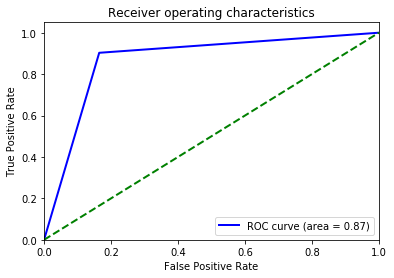

In [22]:
def ROC(df, classes, label):
    print "Extracting features"
    features = get_features(df)
    y = df[label].as_matrix().astype(float)
    X = df[features].as_matrix().astype(float)
    
    print "Binarizing the labels"
    y = label_binarize(y, classes)
    n_classes = y.shape[1]

    print "Adding noisy data"
    random_state = np.random.RandomState(0)
    n_samples, n_features = X.shape
    X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]
    
    print "Splitting into training and testing sets"
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)
    
    print "Classify using CART"
    estimator = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
    estimator.fit(X_train, y_train)
    y_score = estimator.predict(X_test)

    print "Computing `tpr` and `fpr`"
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    print "Computing micro-average ROC curve and ROC area"
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr[2], tpr[2], color='blue',lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='green', lw = 2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristics')
    plt.legend(loc="lower right")
    plt.show()
    
classes = list(mapping.values())
ROC(transformed_df, classes, 'label')